In [2]:
import os
base_dir = os.getcwd()
print(base_dir)

/Users/mia/research/SQUISHY/CH4NetData_gaussianSimulation/ch4net


In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
#example image with no plume
image_id = 167
label_path = f"{base_dir}/test/label/{image_id}.npy"
mbmp_path = f"{base_dir}/test/mbmp/{image_id}.npy"
s2_path = f"{base_dir}/test/s2/{image_id}.npy"

In [5]:
label = np.load(label_path)
mbmp = np.load(mbmp_path)
s2 = np.load(s2_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mia/research/SQUISHY/CH4NetData_gaussianSimulation/ch4net/test/label/167.npy'

In [6]:
plt.imshow(label)
plt.show()

NameError: name 'label' is not defined

Band 1


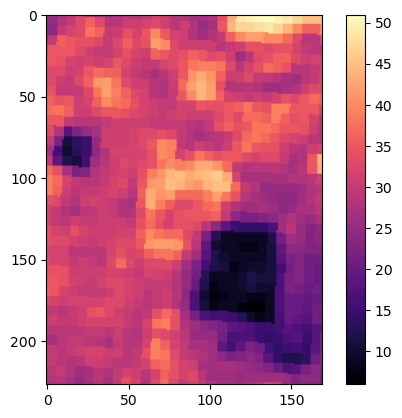

Band 2


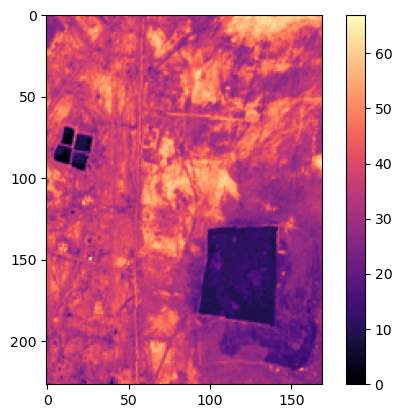

Band 3


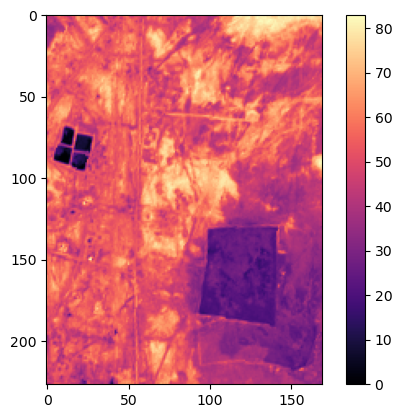

Band 4


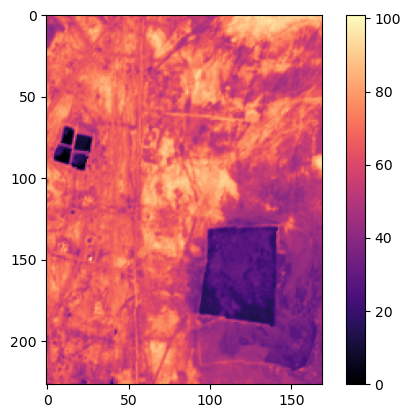

Band 5


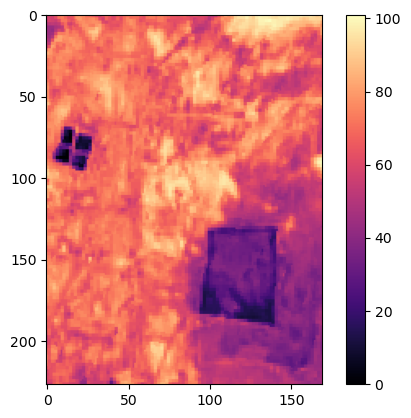

Band 6


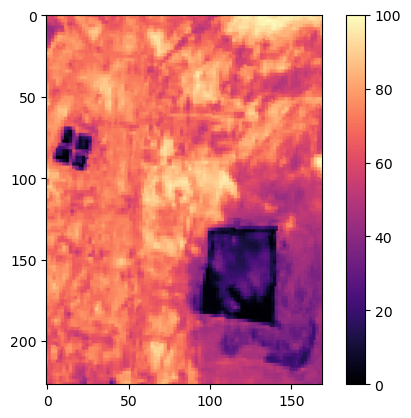

Band 7


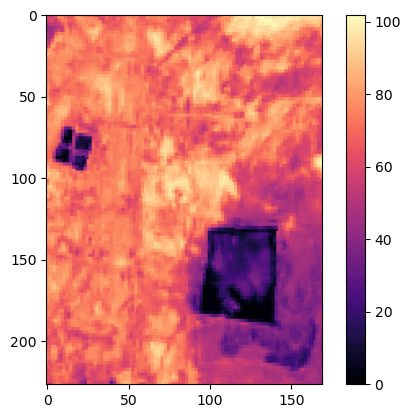

Band 8


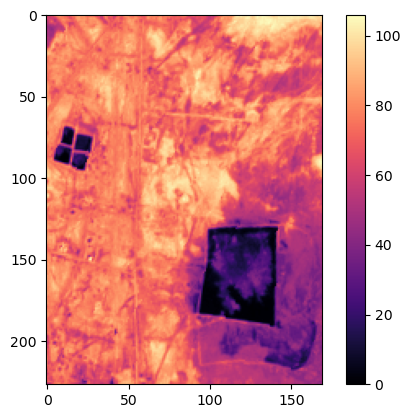

Band 9


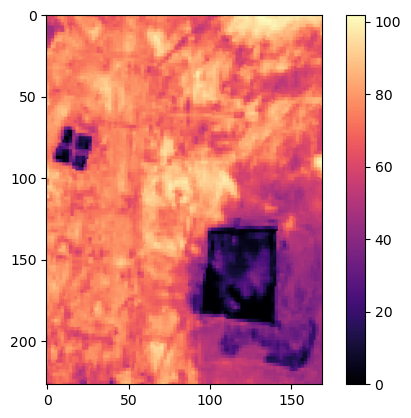

Band 10


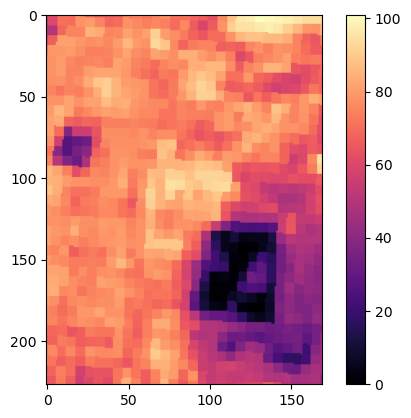

Band 11


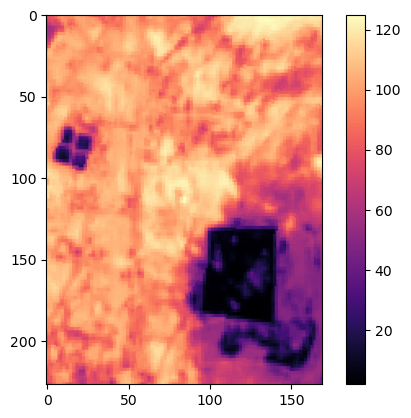

Band 12


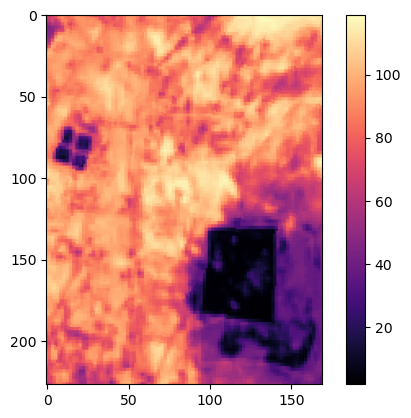

In [6]:
for band in range(1,13):
    print(f"Band {band}")
    plt.imshow(s2[...,band-1], cmap="magma")
    plt.colorbar() #added
    plt.show()

In [11]:
def generate_gaussian_plume(grid_size=(100, 100), emission_rate=None, wind_speed=None):
    """Generate a 2D Gaussian plume."""
    # Parameters
    if emission_rate is None:
        emission_rate = np.random.uniform(0.1, 10)  # kg/s
    if wind_speed is None:
        wind_speed = np.random.uniform(1, 10)  # m/s

    height, width = grid_size

    # Define the grid correctly
    x = np.linspace(0, 1000, width)  # width axis
    y = np.linspace(-500, 500, height)  # height axis
    X, Y = np.meshgrid(x, y)  # (X: width, Y: height)

    # Dispersion coefficients (simplified)
    sigma_y = 50 + 0.1 * X
    sigma_z = 20 + 0.05 * X
    H = 0  # assume release at ground level

    # Gaussian Plume Formula
    C = (emission_rate / (2 * np.pi * wind_speed * sigma_y * sigma_z)) * \
        np.exp(-0.5 * (Y**2) / (sigma_y**2)) * \
        np.exp(-0.5 * (H**2) / (sigma_z**2))

    return C, emission_rate, wind_speed

In [12]:
def add_colored_noise(plume, noise_strength=0.1):
    """Add 2D colored noise to a plume."""
    # Generate random noise
    noise = np.random.normal(0, 1, plume.shape)

    # Apply a simple low-pass filter in frequency domain (to color it)
    noise_fft = np.fft.fft2(noise)

    # Correct: get frequencies
    x = np.fft.fftfreq(plume.shape[1])  # width axis
    y = np.fft.fftfreq(plume.shape[0])  # height axis
    X, Y = np.meshgrid(x, y)  # <- Note: order (x, y) flipped compared to (y, x)

    radius = np.sqrt(X**2 + Y**2)
    filter_mask = np.exp(-radius * 20)  # low-pass filter

    colored_noise = np.fft.ifft2(noise_fft * filter_mask).real

    # Scale and add
    return plume + noise_strength * colored_noise

In [13]:
def embed_plume_into_band12(s2_image, plume, absorption_coefficient=0.01):
    """
    Embed the generated plume into the 12th band of Sentinel-2 image using Beer-Lambert law.
    
    s2_image: np.ndarray with shape (height, width, 12)
    plume: np.ndarray with shape (height, width)
    """
    modified_s2 = s2_image.copy()
    
    I0 = modified_s2[..., 11]  # Band 12, index 11
    tau = absorption_coefficient * plume
    I = I0 * np.exp(-tau)

    modified_s2[..., 11] = I  # replace Band 12

    return modified_s2

{'emission_rate (kg/s)': 6.14946156639649, 'wind_speed (m/s)': 10, 'absorption_coefficient': 0.02}


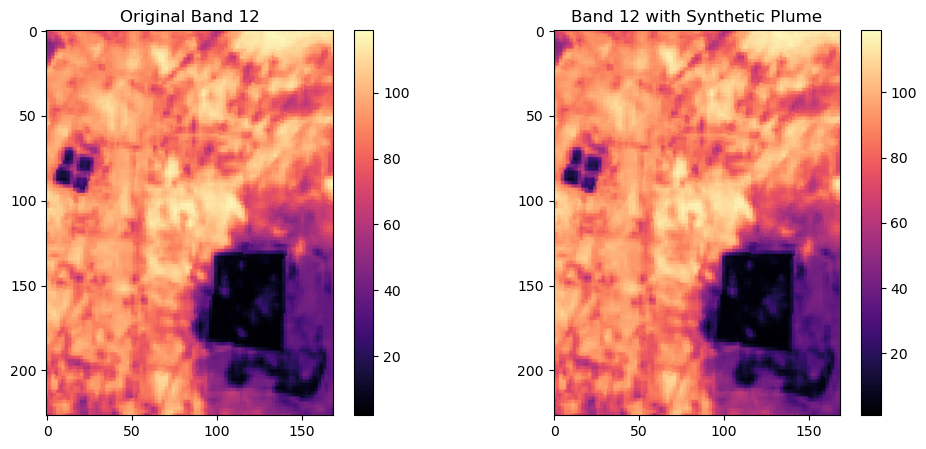

In [17]:
# Assume your image is loaded in `s2` shape (H, W, 12)

# Generate synthetic plume
plume, emission_rate, wind_speed = generate_gaussian_plume(grid_size=s2.shape[:2], wind_speed=10)

# Add turbulence noise
plume_noisy = add_colored_noise(plume, noise_strength=0.05)

# Embed into Band 12
s2_with_plume = embed_plume_into_band12(s2, plume_noisy, absorption_coefficient=0.5)

# Print metadata
metadata = {
    "emission_rate (kg/s)": emission_rate,
    "wind_speed (m/s)": wind_speed,
    "absorption_coefficient": 0.02
}

print(metadata)

# Plot for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title("Original Band 12")
plt.imshow(s2[...,11], cmap="magma")
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Band 12 with Synthetic Plume")
plt.imshow(s2_with_plume[...,11], cmap="magma")
plt.colorbar()

plt.show()